In [1]:
import numpy as np
import os
import random
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt 

# Train test split

In [2]:
img_folder = 'Q:/Personal/poze/ml_datra/sepia'

def split_files(folder_path, test_size = .2):
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    random.shuffle(files)
    
    train = files[:int(len(files) * (1- test_size))]
    test = files[int(len(files) * (1- test_size)):]
    
    return train, test

x_train_filenames, x_test_filenames = split_files(img_folder, test_size=.2)
    

# Filename -> image -> input

In [4]:
def load_images(filename_list, folder_path, size=(100, 100)):
    images = []
    for filename in filename_list:
        image = Image.open(
            os.path.join(folder_path, filename)
        )
        image = image.resize(size)
        image = image.convert('RGB')
        image_arr = np.array(image)
        images += [image_arr]
        
    images_arr = np.array(images)
    return images_arr

x_train = load_images(x_train_filenames, img_folder)
y_train = ['sepia' in filename for filename in x_train_filenames]
x_test = load_images(x_test_filenames, img_folder)
y_test = ['sepia' in filename for filename in x_test_filenames]

# Normalise data

In [6]:
x_train_norm = x_train.astype(np.float32) / 255.0
x_test_norm = x_test.astype(np.float32) / 255.0

# Cnn classifier

In [25]:
class CNN:
    def __init__(self, input_shape, kernel_size=3, pool_size=2):
        self.input_shape = input_shape
        self.kernel_size = kernel_size
        self.pool_size = pool_size
        self.kernel = np.random.randn(kernel_size, kernel_size, input_shape[2]) * 0.1
        self.bias_conv = 0.0
        conv_h = input_shape[0] - kernel_size + 1
        conv_w = input_shape[1] - kernel_size + 1
        pooled_h = conv_h // pool_size
        pooled_w = conv_w // pool_size
        self.fc_input_dim = pooled_h * pooled_w

        self.fc_weights = np.random.randn(self.fc_input_dim, 1) * 0.1
        self.fc_bias = 0.0

        self.loss_history = []
        self.accuracy_history = []

    def convolve(self, image):
        h, w, _ = image.shape
        kh = self.kernel_size
        out = np.zeros((h - kh + 1, w - kh + 1))

        for i in range(out.shape[0]):
            for j in range(out.shape[1]):
                region = image[i:i+kh, j:j+kh, :]
                out[i, j] = np.sum(region * self.kernel) + self.bias_conv
        return out

    def max_pool(self, feature_map):
        h, w = feature_map.shape
        ph = pw = self.pool_size
        out_h, out_w = h // ph, w // pw
        pooled = np.zeros((out_h, out_w))

        for i in range(out_h):
            for j in range(out_w):
                region = feature_map[i*ph:(i+1)*ph, j*pw:(j+1)*pw]
                pooled[i, j] = np.max(region)
        return pooled

    def forward(self, image):
        self.input = image
        self.conv_out = self.convolve(image)
        self.relu_out = relu(self.conv_out)
        self.pooled = self.max_pool(self.relu_out)
        self.flattened = self.pooled.flatten()
        self.fc_z = np.dot(self.flattened, self.fc_weights) + self.fc_bias
        self.output = sigmoid(self.fc_z)
        return self.output

    def backward(self, y_true, learning_rate=0.01):
        d_loss = self.output - y_true  

        d_fc_weights = np.dot(self.flattened[:, np.newaxis], d_loss[np.newaxis])  
        d_fc_bias = d_loss

        self.fc_weights -= learning_rate * d_fc_weights
        self.fc_bias -= learning_rate * d_fc_bias


    def fit(self, X, y, epochs=10, learning_rate=0.01):
        for epoch in range(epochs):
            losses = []
            correct = 0
            for i in range(len(X)):
                output = self.forward(X[i])
                loss = binary_cross_entropy(y[i], output)
                losses.append(loss)

                prediction = int(output > 0.5)
                correct += (prediction == y[i])

                self.backward(y[i], learning_rate)

            avg_loss = np.mean(losses)
            accuracy = correct / len(X)
            self.loss_history.append(avg_loss)
            self.accuracy_history.append(accuracy)
            print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}")
            
    def predict(self, X):
        predictions = []
        for i in range(len(X)):
            output = self.forward(X[i])
            pred_label = int(output > 0.5)
            predictions.append(pred_label)
        return np.array(predictions)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_deriv(x):
    return x * (1 - x)

def relu(x):
    return np.maximum(0, x)

def relu_deriv(x):
    return (x > 0).astype(float)

def binary_cross_entropy(y_true, y_pred):
    eps = 1e-9
    return -np.mean(y_true * np.log(y_pred + eps) + (1 - y_true) * np.log(1 - y_pred + eps))


# Train model

In [26]:
y_train = np.array(y_train).reshape(-1, 1)
classifier = CNN(input_shape=(100, 100, 3))
classifier.fit(x_train_norm, y_train)

C:\Users\Alex\AppData\Local\Temp\ipykernel_16404\2575145507.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prediction = int(output > 0.5)


Epoch 1: Loss = 0.7048
Epoch 2: Loss = 0.6876
Epoch 3: Loss = 0.6690
Epoch 4: Loss = 0.6528
Epoch 5: Loss = 0.6383
Epoch 6: Loss = 0.6251
Epoch 7: Loss = 0.6129
Epoch 8: Loss = 0.6015
Epoch 9: Loss = 0.5908
Epoch 10: Loss = 0.5807


# Test model

In [28]:
y_predict = classifier.predict(x_test)

C:\Users\Alex\AppData\Local\Temp\ipykernel_16404\2575145507.py:87: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_label = int(output > 0.5)


# Metrics

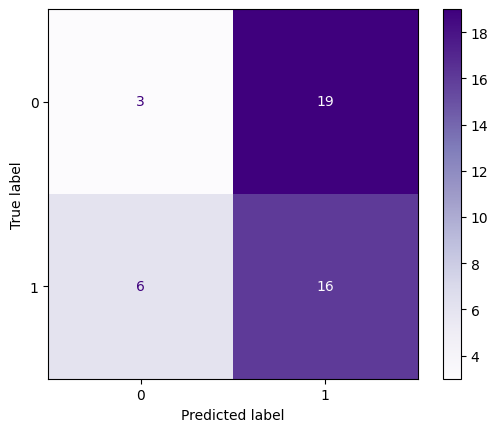

              precision    recall  f1-score   support

       False       0.33      0.14      0.19        22
        True       0.46      0.73      0.56        22

    accuracy                           0.43        44
   macro avg       0.40      0.43      0.38        44
weighted avg       0.40      0.43      0.38        44


In [29]:
ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix(
        y_test, y_predict
    )
).plot(cmap=plt.cm.Purples)
plt.show()

print(classification_report(y_test, y_predict))

# Influenta parametrilor

## Learning rate

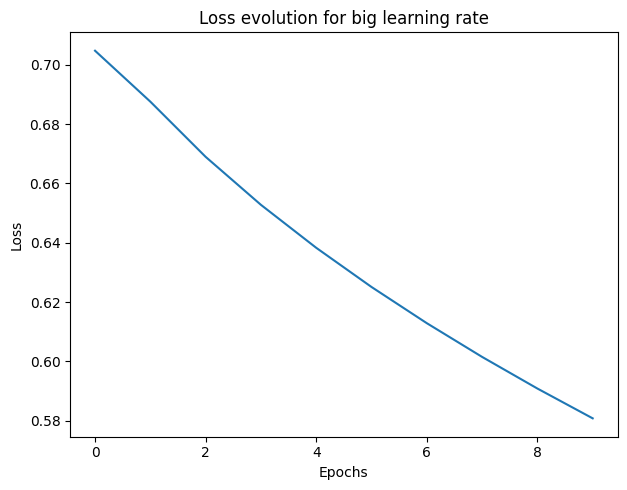

In [31]:
def plot_loss_history(title, history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history, label='Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    plt.tight_layout()
    plt.show()
    
plot_loss_history('Loss evolution for big learning rate', classifier.loss_history)